In [9]:
from xclib.data import data_utils
import numpy as np
import time
import pickle
import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
#Change this later. Make the path as command line argument
X_train = data_utils.read_sparse_file('ass3_parta_data/train_x.txt', force_header=True)
train_class = np.genfromtxt('ass3_parta_data/train_y.txt').reshape(-1, 1)

X_valid = data_utils.read_sparse_file('ass3_parta_data/valid_x.txt', force_header=True)
valid_class = np.genfromtxt('ass3_parta_data/valid_y.txt').reshape(-1, 1)

X_test = data_utils.read_sparse_file('ass3_parta_data/test_x.txt', force_header=True)
test_class = np.genfromtxt('ass3_parta_data/test_y.txt').reshape(-1, 1)

In [11]:
f = open('ass3_parta_data/train_x.txt') 
m,n = f.readlines()[0].rstrip("\n").split(" ")
m,n = int(m),int(n)
f.close()

In [12]:
classes = np.unique(train_class)
pos_class_ind = np.where(train_class == 1)
neg_class_ind = np.where(train_class == 0)

In [13]:
attributes = np.array(range(X_train.A.shape[1]))

### Entropy H(Y) is calculated assuming Y only has two classes - 0 and 1

###### So we use log_2 and use pos and neg_num

In [14]:
def calc_entropyY(train_data, train_class):
    pos_num = train_data[np.where(train_class == 1)[0]].shape[0]
    neg_num = train_data[np.where(train_class == 0)[0]].shape[0]
    
    if (pos_num == 0) or (neg_num == 0):
        entr = 0 #in the limit
    else:
        entr = (pos_num/(pos_num+neg_num))*np.log2((pos_num+neg_num)/pos_num) + (neg_num/(pos_num+neg_num))*np.log2((pos_num+neg_num)/neg_num)
        
    return entr

In [15]:
#Entropy of Raw data
start = time.time()
print(calc_entropyY(X_train.A, train_class))
print("time = ", time.time()-start)

0.997775157550985
time =  0.08731985092163086


#### Reduction in Error is given by H(Y|X) by using value to split at the node
H(Y|X) 

       = H(Y|X=x)P(X=x)  -- find the two splits 

       = H(Y=y|X=x)P(X=x) -- find the entropy of both the splits. 

       = calc_entropy(split1, train_class_split1).P(X=x)
    

In [16]:
def calc_red_error(train_data, split, split_class, train_class):
    #print("In reduction of Error Module")
    #print(train_data.shape[0])
    error = 0
    for i in range(len(split)):
    #    print("Split shape = ", split[i].shape)
        error += (split[i].shape[0]/train_data.shape[0])*calc_entropyY(split[i], split_class[i])
    #print("Reduction in error = ", error)
    return error


In [17]:
def find_best_attr(train_data, train_class):
    #max_mutual_info = 0;   This doesnt work for the cases when mutual info becomes negative. 
    max_mutual_info = float("-inf");
    median = (np.median(train_data, axis=0))        
    #print(median)
    for i in range(len(attributes)):
        split = []
        split_class = []
        split.append(train_data[np.where(train_data[:,i] <= median[i])])
        split.append(train_data[np.where(train_data[:,i] > median[i])])
        split_class.append(train_class[np.where(train_data[:,i] <= median[i])])
        split_class.append(train_class[np.where(train_data[:,i] > median[i])])
        mutual_info = calc_entropyY(train_data, train_class) - calc_red_error(train_data, split, split_class, train_class)
        #print(mutual_info)
        if max_mutual_info < mutual_info:
            max_mutual_info = mutual_info
            best_attr = attributes[i]
            thres = median[i]
    return max_mutual_info, best_attr, thres

In [18]:
start = time.time()
print(find_best_attr(X_train.A, train_class))
print(time.time()-start)

(0.0793751756882577, 217, 0.0)
30.58475685119629


### Every Node  in the tree will have the following contents:

1. Left Subtree
2. Right Subtree
3. Attribute Name on which this node will split
4. Threshold of the attribute for left and right subtree (Median) - int value
5. Entropy
6. Whether this node is leaf or not - True/False
7. A final value of Y=0 or Y=1 in case of leaf

In [19]:
class newNode(object):
    def __init__(self, attr, Th, value):
        self.left = None
        self.right = None
        self.attribute = attr
        self.threshold = Th
        self.value = value
        self.leaf = False
        self.final = None
        self.parent = None
    
    def find_root(self):
        while (self.parent is not None):
            self = self.parent
            self = self.find_root()
        root = self
        return root

    def calc_accuracy(self, tra_data, tra_classes, val_data, val_classes, test_data, test_classes):
        root = self.find_root()
        #print("Root found at = ", root)
        t_acc = 0; v_acc = 0; tes_acc = 0
        for i in range(len(tra_data)):
            pred = predict(root, tra_data[i])
            if (pred is None):
                continue
            if (pred == tra_classes[i]):
                t_acc+=1
        for i in range(len(val_data)):
            pred = predict(root, val_data[i])
            if (pred is None):
                continue            
            if (pred == val_classes[i]):
                v_acc += 1
        for i in range(len(test_data)):
            pred = predict(root, test_data[i])
            if (pred is None):
                continue
            if(pred == test_classes[i]):
                tes_acc+=1
        
        return t_acc/len(tra_classes), v_acc/len(val_classes), tes_acc/len(test_classes);

In [20]:
class Tree(object):
    def __init__(self):
        self.tree = None
    def buildTree(self, data, classes, parent, depth, d_thres):
        self.tree = growTree(data, classes, parent, depth, d_thres)

In [21]:
def predict(tree, data):
    if tree is None:
        return None
    if tree.leaf:
        return tree.final
    if tree.left is None and tree.right is None:
        if tree.value[0] > tree.value[1]:
            return 0
        else:
            return 1
    if data[tree.attribute] <= tree.threshold:
        return predict(tree.left, data)
    elif data[tree.attribute] > tree.threshold:
        return predict(tree.right, data)


In [22]:
def growTree(train_data, classes, parent, depth, depth_threshold):
    global num_nodes
    pos_num = train_data[np.where(classes == 1)[0]].shape[0]
    neg_num = train_data[np.where(classes == 0)[0]].shape[0]
    #print("The number of nodes present in the graph = ", num_nodes)
    #print(neg_num, pos_num)

    if (depth == depth_threshold):
        num_nodes+=1
        leaf = newNode(None, None, None)
        leaf.parent = parent
        leaf.leaf = True
        if (pos_num > neg_num):
            leaf.final = 1
        else:
            leaf.final = 0
        return leaf
            
    elif(pos_num == 0 or neg_num == 0):
        num_nodes+=1
        leaf = newNode(None, None, None)
        leaf.leaf = True
        leaf.parent = parent
        
        if(pos_num != 0):
            leaf.final = 1
        elif(neg_num != 0):
            leaf.final = 0
        return leaf
        
    else:
        mutual_info, best_attr, thresh = find_best_attr(train_data, classes)
        #print("Best Attribute with Threshold = ", best_attr, thresh)
        num_nodes+=1
        left_split = train_data[np.where(train_data[:,best_attr] <= thresh)]
        right_split = train_data[np.where(train_data[:,best_attr] > thresh)]
        left_split_class = classes[np.where(train_data[:,best_attr] <= thresh)]
        right_split_class = classes[np.where(train_data[:,best_attr] > thresh)]
        
        if (left_split.shape[0] == 0):
            leaf = newNode(None, None, None)
            leaf.parent = parent
            
            leaf.leaf = True
            pos = left_split[np.where(left_split_class == 1)[0]].shape[0]
            neg = left_split[np.where(left_split_class == 0)[0]].shape[0]
            if (pos>neg):
                leaf.final = 1
            else:
                leaf.final = 0
            return leaf
        elif (right_split.shape[0] == 0):
            leaf = newNode(None, None, None)
            leaf.leaf = True
            leaf.parent = parent
            
            pos = right_split[np.where(right_split_class == 1)[0]].shape[0]
            neg = right_split[np.where(right_split_class == 0)[0]].shape[0]
            if (pos>neg):
                leaf.final = 1
            else:
                leaf.final = 0
            return leaf
        else:
            addNode = newNode(best_attr, thresh, [neg_num, pos_num])
            addNode.parent = parent
            #print(parent)
            #print("The value of the class examples in this node = ", addNode.value)
            #print("Building left tree on =", left_split.shape[0])
            addNode.left = growTree(left_split, left_split_class, addNode, depth+1, depth_threshold)
            #print("Building right tree in = ", right_split.shape[0])
            addNode.right = growTree(right_split, right_split_class, addNode, depth+1, depth_threshold)
            return addNode

In [18]:
nodes = []
time_taken = []
train_acc=[]; val_acc= []; test_acc = []


start = time.time()
num_nodes = 0
root = Tree()
root.buildTree(X_train.A, train_class, None, 0, float("inf"))
    
#root = growTree(X_train.A, train_class, 0, 8)


In [20]:
print("Time Taken to grow tree = {} sec".format(time.time() - start))

Time Taken to grow tree = 795.9404263496399 sec


In [67]:
print(num_nodes)

19999


In [23]:
with open('tree_b.pickle', 'rb') as f:
    root = pickle.load(f)

In [15]:
train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)

In [19]:
def printPreorder(graph): 
    global n
    if graph: 
        n+=1     #To Count the number of nodes 
  
        print(graph, graph.attribute, graph.leaf, graph.parent, graph.final), 
        
        printPreorder(graph.left)

        printPreorder(graph.right) 
  

Test Accuracy = 71.67%
Train Accuracy = 
Validation Accuracy = 

In [80]:
print("--------------Original Tree------------------------------\n")
print("Number of Nodes = ", n)
print("The Training Accuracy on Full-Grown Tree is = {:2.3f}%".format(train_acc*100))
print("The Vaidation Accuracy on Full-Grown Tree is = {:2.3f}%".format(val_acc*100))
print("The Test Accuracy on Full-Grown Tree is = {:2.3f}%".format(test_acc*100))

--------------Original Tree------------------------------

Number of Nodes =  19999
The Training Accuracy on Full-Grown Tree is = 81.481%
The Vaidation Accuracy on Full-Grown Tree is = 78.500%
The Test Accuracy on Full-Grown Tree is = 79.027%


# Post Pruning the tree by traversing in PreOrder -> root-left-right
### Leaf Nodes Since they are not decision Nodes

In [83]:
with open('tree_b.pickle', 'rb') as f:
    root = pickle.load(f)

In [84]:
def PreOrderPrune(rootT): 
    global prune_num
    if rootT.attribute is None:
        return rootT
      
    if rootT is None:
        return None
    
    if rootT.left.leaf == True and rootT.right.leaf == True:
        prune_num+=1
        new_root = rootT
        new_root.leaf = True
        new_root.final = [1 if rootT.value[0]<rootT.value[1] else 0][0]
        temp = rootT
        rootT = None
        del(temp)
        return new_root

    rootT.left = PreOrderPrune(rootT.left) 
        
    rootT.right = PreOrderPrune(rootT.right)

    return rootT

In [85]:
train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)
train_acc_prune_leaf = [train_acc]
val_acc_prune_leaf = [val_acc]
test_acc_prune_leaf = [test_acc]
pruned_nodes = [0]
for i in range(15):
    prune_num=0
    PreOrderPrune(root.tree)
    pruned_nodes.append(prune_num)
    train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)    
    if(val_acc > val_acc_prune_leaf[-1]):
        optimal_idx = i+1
        newG = copy.deepcopy(root.tree)
    train_acc_prune_leaf.append(train_acc)
    val_acc_prune_leaf.append(val_acc)
    test_acc_prune_leaf.append(test_acc)

In [86]:
train_acc_prune_leaf = [np.round(x*100,2) for x in train_acc_prune_leaf]
val_acc_prune_leaf = [np.round(x*100,2) for x in val_acc_prune_leaf]
test_acc_prune_leaf = [np.round(x*100,2) for x in test_acc_prune_leaf]

In [87]:
pruned_total = [sum(pruned_nodes[:x]) for x in range(1, len(pruned_nodes) + 1)]

nodes_left = [n-x for x in pruned_total]
print(nodes_left)

[19999, 17457, 15010, 12890, 11134, 9712, 8550, 7599, 6821, 6172, 5620, 5151, 4749, 4394, 4091, 3829]


In [88]:
train_acc, val_acc, test_acc = newG.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)

In [89]:
print("--------------Optimal Tree after Iterative Pruning------------------------------\n")
print("Number of Nodes = ", nodes_left[optimal_idx])
print("The Training Accuracy on Full-Grown Tree is = {:2.3f}%".format(train_acc*100))
print("The Vaidation Accuracy on Full-Grown Tree is = {:2.3f}%".format(val_acc*100))
print("The Test Accuracy on Full-Grown Tree is = {:2.3f}%".format(test_acc*100))

--------------Optimal Tree after Iterative Pruning------------------------------

Number of Nodes =  6821
The Training Accuracy on Full-Grown Tree is = 81.501%
The Vaidation Accuracy on Full-Grown Tree is = 79.038%
The Test Accuracy on Full-Grown Tree is = 79.064%


In [90]:
print("The Training Accuracy are = ", train_acc_prune_leaf)
print("The Validation Accuracy are = ", val_acc_prune_leaf)
print("The Test Accuracy are = ", test_acc_prune_leaf)

The Training Accuracy are =  [83.87, 85.81, 85.51, 84.8, 83.97, 83.21, 82.59, 82.0, 81.5, 81.14, 80.72, 80.26, 79.9, 79.61, 79.33, 78.97]
The Validation Accuracy are =  [71.88, 77.1, 77.6, 78.45, 78.71, 78.63, 78.73, 78.81, 79.04, 78.88, 78.67, 78.37, 78.2, 78.13, 78.01, 77.81]
The Test Accuracy are =  [71.67, 77.45, 78.34, 79.07, 79.19, 79.22, 79.19, 79.26, 79.06, 78.97, 78.69, 78.39, 78.56, 78.48, 78.42, 78.19]


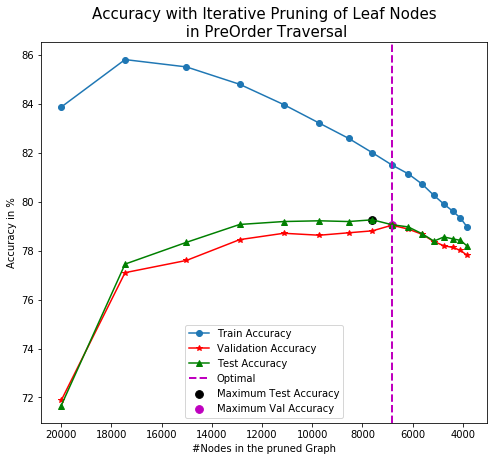

In [110]:
x = [i for i in range(16)]

fig = plt.figure(figsize=(8,7))
ax1=fig.add_subplot(111)

ax1.plot(nodes_left, train_acc_prune_leaf, marker='o', label='Train Accuracy')
ax1.plot(nodes_left, val_acc_prune_leaf, marker='*', c='r', label='Validation Accuracy')
ax1.plot(nodes_left, test_acc_prune_leaf, marker='^', c='g', label='Test Accuracy')
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.axvline(x=nodes_left[optimal_idx], c='m',linestyle='--', linewidth=2, label='Optimal')
ax1.scatter(nodes_left[optimal_idx-1], test_acc_prune_leaf[optimal_idx-1], c='k', marker='o',s=60, label='Maximum Test Accuracy')
ax1.scatter(nodes_left[optimal_idx], val_acc_prune_leaf[optimal_idx], c='m', marker='o',s=60, label='Maximum Val Accuracy')
ax1.set_xlabel("#Nodes in the pruned Graph")
ax1.set_ylabel("Accuracy in %")
ax1.set_title("Accuracy with Iterative Pruning of Leaf Nodes\n in PreOrder Traversal", fontsize=15)
ax1.legend()
#plt.savefig("plots/IterativeLeafPruningPreOrder.png", dpi=1000, bbox_inches='tight')

plt.show()


# Try Post Pruning in different traversal order - Inorder -> Left-Root-Right

In [8]:
with open('tree_b.pickle', 'rb') as f:
    root = pickle.load(f)

AttributeError: Can't get attribute 'Tree' on <module '__main__'>

In [70]:
def InOrderPrune(rootT): 
    #print(rootT.attribute)
    global prune_num
        
    if rootT.attribute is None:
        return rootT
      
    if rootT is None:
        return None
    
    rootT.left = InOrderPrune(rootT.left) 
    
    if rootT.left.leaf == True and rootT.right.leaf == True:
        prune_num+=1
        #print("Leaf", rootT.value)
        new_root = rootT
        new_root.leaf = True
        new_root.final = [1 if rootT.value[0]<rootT.value[1] else 0][0]
        temp = rootT
#         rootT.left = None
#         rootT.right = None
        rootT = None
        
        del(temp)
        #print("retunring", new_root.attribute, new_root.final)
        return new_root
        
    rootT.right = InOrderPrune(rootT.right)

    return rootT

In [71]:
train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)
train_acc_prune_leaf = [train_acc]
val_acc_prune_leaf = [val_acc]
test_acc_prune_leaf = [test_acc]
pruned_nodes = [0]
for i in range(15):
    prune_num=0
    InOrderPrune(root.tree)
    pruned_nodes.append(prune_num)
    train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)    
    if(val_acc > val_acc_prune_leaf[-1]):
        optimal_idx = i+1
        newG = copy.deepcopy(root.tree)
    train_acc_prune_leaf.append(train_acc)
    val_acc_prune_leaf.append(val_acc)
    test_acc_prune_leaf.append(test_acc)

In [72]:
train_acc_prune_leaf = [np.round(x*100,2) for x in train_acc_prune_leaf]
val_acc_prune_leaf = [np.round(x*100,2) for x in val_acc_prune_leaf]
test_acc_prune_leaf = [np.round(x*100,2) for x in test_acc_prune_leaf]

In [73]:
pruned_total = [sum(pruned_nodes[:x]) for x in range(1, len(pruned_nodes) + 1)]

nodes_left = [n-x for x in pruned_total]
print(nodes_left)

[19999, 15624, 11261, 7561, 4887, 3126, 2142, 1499, 1089, 898, 771, 745, 719, 693, 667, 641]


In [74]:
train_acc, val_acc, test_acc = newG.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)

In [75]:
print("--------------Optimal Tree after Iterative Pruning------------------------------\n")
print("Number of Nodes = ", nodes_left[optimal_idx])
print("The Training Accuracy on Full-Grown Tree is = {:2.3f}%".format(train_acc*100))
print("The Vaidation Accuracy on Full-Grown Tree is = {:2.3f}%".format(val_acc*100))
print("The Test Accuracy on Full-Grown Tree is = {:2.3f}%".format(test_acc*100))

--------------Optimal Tree after Iterative Pruning------------------------------

Number of Nodes =  7561
The Training Accuracy on Full-Grown Tree is = 81.481%
The Vaidation Accuracy on Full-Grown Tree is = 78.500%
The Test Accuracy on Full-Grown Tree is = 79.027%


In [76]:
print("The Training Accuracy are = ", train_acc_prune_leaf)
print("The Validation Accuracy are = ", val_acc_prune_leaf)
print("The Test Accuracy are = ", test_acc_prune_leaf)

The Training Accuracy are =  [83.87, 84.77, 83.1, 81.48, 79.29, 77.93, 75.61, 73.67, 72.44, 69.09, 67.05, 52.78, 52.78, 52.78, 52.78, 52.78]
The Validation Accuracy are =  [71.88, 77.37, 78.12, 78.5, 77.74, 76.91, 74.76, 73.02, 71.79, 68.55, 66.58, 52.24, 52.24, 52.24, 52.24, 52.24]
The Test Accuracy are =  [71.67, 77.84, 78.5, 79.03, 77.94, 77.4, 75.32, 73.5, 72.37, 68.77, 66.8, 52.94, 52.94, 52.94, 52.94, 52.94]


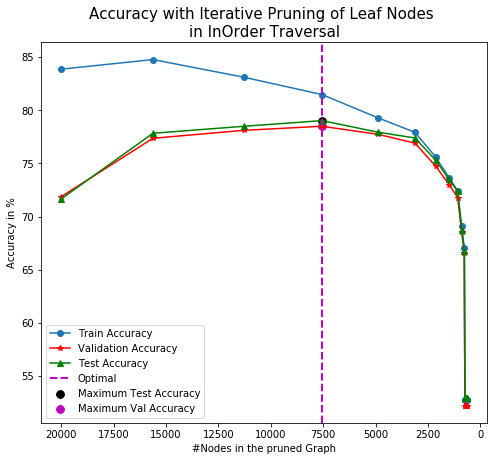

In [78]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,7))
ax1=fig.add_subplot(111)

ax1.plot(nodes_left, train_acc_prune_leaf, marker='o', label='Train Accuracy')
ax1.plot(nodes_left, val_acc_prune_leaf, marker='*', c='r', label='Validation Accuracy')
ax1.plot(nodes_left, test_acc_prune_leaf, marker='^', c='g', label='Test Accuracy')
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.axvline(x=nodes_left[optimal_idx], c='m',linestyle='--', linewidth=2, label='Optimal')
ax1.scatter(nodes_left[optimal_idx], test_acc_prune_leaf[optimal_idx], c='k', marker='o',s=60, label='Maximum Test Accuracy')
ax1.scatter(nodes_left[optimal_idx], val_acc_prune_leaf[optimal_idx], c='m', marker='o',s=60, label='Maximum Val Accuracy')
ax1.set_xlabel("#Nodes in the pruned Graph")
ax1.set_ylabel("Accuracy in %")
ax1.set_title("Accuracy with Iterative Pruning of Leaf Nodes \nin InOrder Traversal", fontsize=15)
ax1.legend()

#plt.savefig("plots/IterativeLeafPruningInOrder.png", dpi=1000, bbox_inches='tight')

plt.show()


# Trial

In [24]:
with open('tree_b.pickle', 'rb') as f:
    root = pickle.load(f)

In [25]:
def Prune(rootT, depth): 
    #print(rootT.attribute)
    global prune_num, d
    if (d <= depth):
        return rootT
    else:
        
        rootT.left = Prune(rootT.left, depth+1) 
        
        if (prune_num == 1):
            return rootT
        
        if rootT.attribute is None:
            return rootT

        if rootT is None:
            return None
    
        new_root.leaf = True
        new_root.final = [1 if rootT.value[0]<rootT.value[1] else 0][0]
        temp = rootT
        new_root.left = None
        new_root.right = None
        prune_num+=1
#         rootT.left = None
#         rootT.right = None
        rootT = None

        del(temp)
        #print("retunring", new_root.attribute, new_root.final)
        return new_root

        
        rootT.right = Prune(rootT.right, depth+1)

        return rootT

In [71]:
train_acc, val_acc, test_acc = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)
train_acc_prune_leaf = [train_acc]
val_acc_prune_leaf = [val_acc]
test_acc_prune_leaf = [test_acc]
pruned_nodes = [0]
d = 2
depth = 1
temp_tree = deepcopy(root.tree)
while(True):
    prune_num=0
    Prune(temp_tree.left, depth)
    pruned_nodes.append(prune_num)
    train_acc, val_acc, test_acc = temp_tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)    
    if(val_acc > val_acc_prune_leaf[-1]):
        Prune(temp_tree.right)
    else:
        temp_tree = deepcopy(root.tree)
        Prune(temp_tree.left, depth+1)
        
    train_acc_prune_leaf.append(train_acc)
    val_acc_prune_leaf.append(val_acc)
    test_acc_prune_leaf.append(test_acc)

In [72]:
train_acc_prune_leaf = [np.round(x*100,2) for x in train_acc_prune_leaf]
val_acc_prune_leaf = [np.round(x*100,2) for x in val_acc_prune_leaf]
test_acc_prune_leaf = [np.round(x*100,2) for x in test_acc_prune_leaf]

In [73]:
pruned_total = [sum(pruned_nodes[:x]) for x in range(1, len(pruned_nodes) + 1)]

nodes_left = [n-x for x in pruned_total]
print(nodes_left)

[19999, 15624, 11261, 7561, 4887, 3126, 2142, 1499, 1089, 898, 771, 745, 719, 693, 667, 641]


In [74]:
train_acc, val_acc, test_acc = newG.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)

In [75]:
print("--------------Optimal Tree after Iterative Pruning------------------------------\n")
print("Number of Nodes = ", nodes_left[optimal_idx])
print("The Training Accuracy on Full-Grown Tree is = {:2.3f}%".format(train_acc*100))
print("The Vaidation Accuracy on Full-Grown Tree is = {:2.3f}%".format(val_acc*100))
print("The Test Accuracy on Full-Grown Tree is = {:2.3f}%".format(test_acc*100))

--------------Optimal Tree after Iterative Pruning------------------------------

Number of Nodes =  7561
The Training Accuracy on Full-Grown Tree is = 81.481%
The Vaidation Accuracy on Full-Grown Tree is = 78.500%
The Test Accuracy on Full-Grown Tree is = 79.027%


In [76]:
print("The Training Accuracy are = ", train_acc_prune_leaf)
print("The Validation Accuracy are = ", val_acc_prune_leaf)
print("The Test Accuracy are = ", test_acc_prune_leaf)

The Training Accuracy are =  [83.87, 84.77, 83.1, 81.48, 79.29, 77.93, 75.61, 73.67, 72.44, 69.09, 67.05, 52.78, 52.78, 52.78, 52.78, 52.78]
The Validation Accuracy are =  [71.88, 77.37, 78.12, 78.5, 77.74, 76.91, 74.76, 73.02, 71.79, 68.55, 66.58, 52.24, 52.24, 52.24, 52.24, 52.24]
The Test Accuracy are =  [71.67, 77.84, 78.5, 79.03, 77.94, 77.4, 75.32, 73.5, 72.37, 68.77, 66.8, 52.94, 52.94, 52.94, 52.94, 52.94]


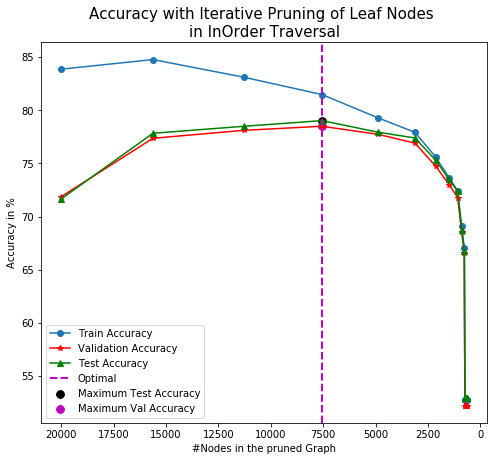

In [78]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,7))
ax1=fig.add_subplot(111)

ax1.plot(nodes_left, train_acc_prune_leaf, marker='o', label='Train Accuracy')
ax1.plot(nodes_left, val_acc_prune_leaf, marker='*', c='r', label='Validation Accuracy')
ax1.plot(nodes_left, test_acc_prune_leaf, marker='^', c='g', label='Test Accuracy')
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.axvline(x=nodes_left[optimal_idx], c='m',linestyle='--', linewidth=2, label='Optimal')
ax1.scatter(nodes_left[optimal_idx], test_acc_prune_leaf[optimal_idx], c='k', marker='o',s=60, label='Maximum Test Accuracy')
ax1.scatter(nodes_left[optimal_idx], val_acc_prune_leaf[optimal_idx], c='m', marker='o',s=60, label='Maximum Val Accuracy')
ax1.set_xlabel("#Nodes in the pruned Graph")
ax1.set_ylabel("Accuracy in %")
ax1.set_title("Accuracy with Iterative Pruning of Leaf Nodes \nin InOrder Traversal", fontsize=15)
ax1.legend()

#plt.savefig("plots/IterativeLeafPruningInOrder.png", dpi=1000, bbox_inches='tight')

plt.show()
